In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file. 
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [2]:
# import os
# import sys
# import torch
# need_pytorch3d=False
# try:
    # import pytorch3d
# except ModuleNotFoundError:
    # need_pytorch3d=True
# if need_pytorch3d:
#     if torch.__version__.startswith("1.9") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{torch.__version__[0:5:2]}"
#         ])
#         !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
#         !tar xzf 1.10.0.tar.gz
#         os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
#         !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [3]:
import os
import torch
from torch import nn
from torchvision.transforms import RandomAffine, Resize
import optuna


import matplotlib.pyplot as plt

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torchvision.transforms import RandomAffine, Resize

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    NormalMeshRenderer,
    MeshRasterizer,  
    NormalSoftPhongShader,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    TexturesUV,
    tbn_matrices,
)

from pytorch3d.renderer.mesh import tbn_matrices
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [4]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [5]:
 from utils.plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [6]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [7]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
# obj_filename = os.path.join(DATA_DIR, "cube_mesh/six_colour_cube.obj")


# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center)
mesh.scale_verts_((0.75 / float(scale)));

In [8]:
# cos_similarity = torch.nn.CosineSimilarity(dim=3)
# transform_range_horizontal = 100/1024
# transform_range_vertical = 100/1024
# transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical), fill=0.5)
# cos_similarity(mesh.normalmaps.maps_padded(), transform(mesh.normalmaps.maps_padded().permute(0,3,1,2)).permute(0,2,3,1).squeeze().cpu().numpy()).mean()

In [9]:
# plt.figure(figsize=(7,7))
# texture_image=mesh.normalmaps.maps_padded()
# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().numpy())
# plt.axis("off");

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


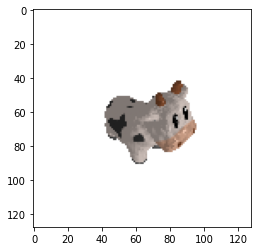

In [10]:
imsize = 128
# lights = PointLights(device=device, location=[[0.0, 0.0, -1.5]])
lights = DirectionalLights(direction=[[0.0, 0.0, -1.0]], device=device)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = 45
rand_azim = 135
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
TBN_matrices = tbn_matrices(mesh)
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)
random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
plt.imshow(random_target.cpu().numpy()[0])

In [11]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 30
batch_views = 1
imsize = 128
# Get a batch of viewing angles. 
elev = np.random.permutation(torch.linspace(0, 360, num_views))
azim = np.random.permutation(torch.linspace(-180, 180, num_views))
# elev = np.array([45, 45, 225, 225])
# azim = np.array([-45, 135, -45, 135])

def train_test_split(list):
    return list[:len(list)//2], list[len(list)//2:]

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
# cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
# Changed to novel view
rand_elev = torch.rand((1,))*360
rand_azim = torch.rand((1,))*360 - 180
R_novel, T_novel = look_at_view_transform(dist=2.7, elev=rand_elev, azim=rand_azim)

camera = OpenGLPerspectiveCameras(device=device, R=R_novel, 
                                  T=T_novel) 


# camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 

normals_hook = torch.Tensor()
raster_settings = RasterizationSettings(
    image_size=imsize, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = NormalMeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=NormalSoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=TBN_matrices,
    )
)

# for i
# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_views)
target_rgb = []
target_cameras = []
target_normals = []
print()
# Render small batches of target views on GPU and append to list to be later converted to CPU tensor
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    target_images_batch, normals = renderer(meshes, cameras=cameras, lights=lights)

    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_rgb_batch = [target_images_batch[i, ..., :3].cpu() for i in range(batch_views)]
    target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_rgb.extend(target_rgb_batch)
    target_cameras.extend(target_cameras_batch)
    target_normals.append(normals)


# 50/50 split of views for train/test
target_rgb, test_rgb = train_test_split(target_rgb)
target_cameras, test_cameras = train_test_split(target_cameras)
target_normals, test_normals = train_test_split(target_normals)

random_target, _ = renderer(mesh, cameras=camera, lights=lights)
random_target = random_target[...,:3]
print(len(target_rgb), len(target_cameras))


15 15


Visualize the dataset:

/tmp/ipykernel_11162/1255958388.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)
/tmp/ipykernel_11162/1255958388.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)


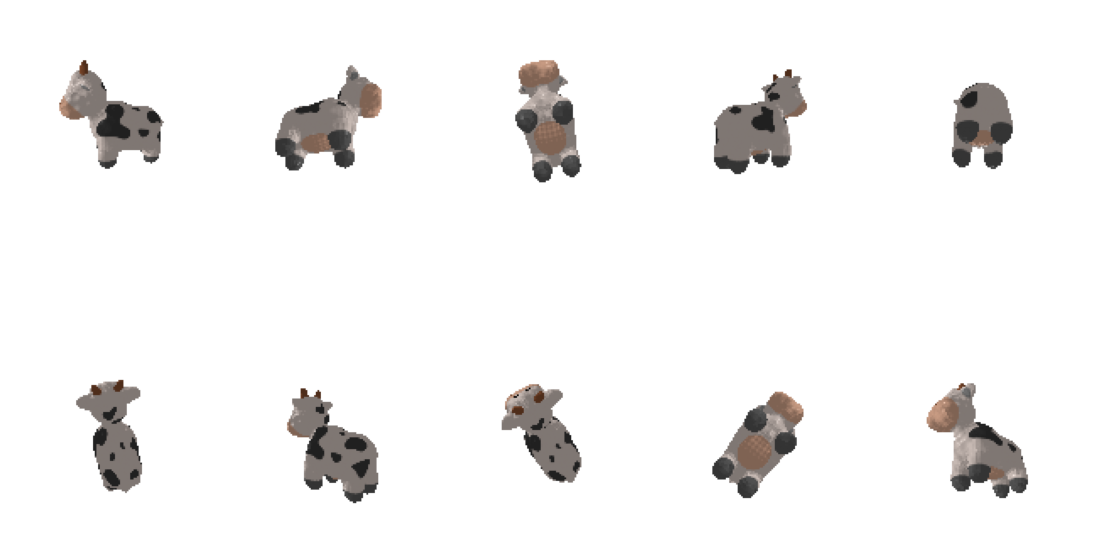

In [12]:
# RGB images
print()

image_grid(np.asarray(target_rgb[:10]), rows=2, cols=5, rgb=True)
plt.show()

Later in this tutorial, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object.  We construct a soft silhouette shader to render this alpha channel.

In [13]:
# # Rasterization settings for silhouette rendering  
# sigma = 1e-4
# raster_settings_silhouette = RasterizationSettings(
#     image_size=imsize, 
#     blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
#     faces_per_pixel=50, 
#     perspective_correct=False,
# )

# # Silhouette renderer 
# renderer_silhouette = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings_silhouette
#     ),
#     shader=SoftSilhouetteShader()
# )

# # # Render silhouette images.  The 3rd channel of the rendering output is 
# # # the alpha/silhouette channel
# # silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
# # print(silhouette_images.shape)
# # target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# # # Visualize silhouette images
# # image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
# # plt.show()

/tmp/ipykernel_11162/579964652.py:37: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.asarray(target_silhouette[:10])[0].shape)
/tmp/ipykernel_11162/579964652.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.asarray(target_silhouette[:10])[0].shape)
/tmp/ipykernel_11162/579964652.py:38: FutureWarning: The input object of type 'Tensor' is an array

torch.Size([128, 128])


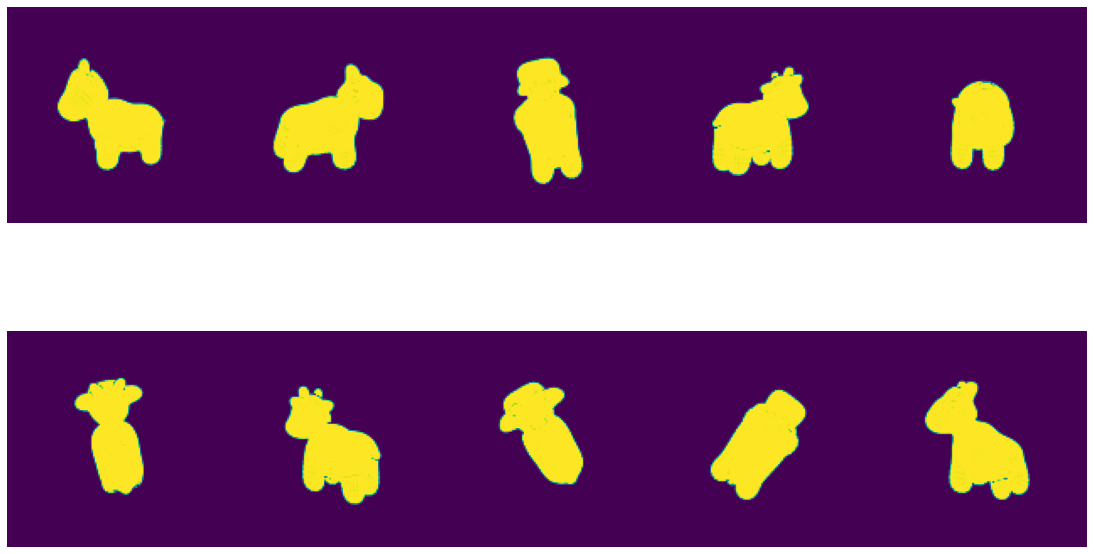

In [14]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
target_silhouette = []
silhouette_images = []
for i in range(num_views // batch_views):
    # Create cameras for rendering the batch
    cameras = OpenGLPerspectiveCameras(device=device, R=R[i*batch_views:(i+1)*batch_views], T=T[i*batch_views:(i+1)*batch_views])
    # Render the cow mesh from each viewing angle
    silhouette_images_batch = renderer_silhouette(meshes, cameras=cameras, lights=lights)
    silhouette_images.extend(silhouette_images_batch.cpu())
    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    target_silhouette_batch = [silhouette_images_batch[i, ..., 3].cpu() for i in range(batch_views)]
    # target_cameras_batch = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                        #    T=T[None, i, ...]) for i in range(i*batch_views,(i+1)*batch_views)]
    target_silhouette.extend(target_silhouette_batch)
    # target_cameras.extend(target_cameras_batch)
# Visualize silhouette images
print(np.asarray(target_silhouette[:10])[0].shape)
image_grid(np.asarray(silhouette_images[:10]), rows=2, cols=5, rgb=False)
plt.show()

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [15]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette, 
                         target_image=random_target[0], title='', 
                         silhouette=False, camera = camera):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images, _ = renderer(predicted_mesh, cameras=camera)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [16]:
# We initialize the source shape to be a sphere of radius 1.  
silhouette_src_mesh = ico_sphere(4, device)
# src_mesh = mesh.clone()

torch.Size([2562]) torch.Size([2562])
torch.Size([2562, 2]) tensor(1., device='cuda:0') tensor(0., device='cuda:0')
Target shapes faces: torch.Size([1, 5856, 3]), verts: torch.Size([1, 2930, 3])
Target shapes facesUVs: torch.Size([1, 5856, 3]), vertsUVs: torch.Size([1, 3225, 2])
torch.Size([2562, 3])


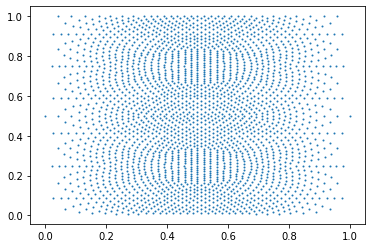

In [17]:
# Functions from my L4 project
def to_geocentric(lat, lon):
    """
    Converts a latitude longitude pair to geocentric X Y Z coordinates
    """
    lat = np.radians(lat)
    lon = np.radians(lon)
    return np.array([np.cos(lat) * np.cos(lon), np.cos(lat) * np.sin(lon), np.sin(lat)])

# lat lon but longitude is scaled to half to have a square representation
def to_lat_lon(coords):
    """
    Converts X Y Z geocentric coordinates into latitude and longitude
    """
    return np.array([np.degrees(np.arcsin(coords[2])), np.degrees(np.arctan2(coords[1], coords[0]))])

# Creating UVs for sphere using equirectangular projection with scaled v axis
sphere_verts = silhouette_src_mesh.verts_packed()
xyz_to_u = torch.rad2deg(torch.arcsin(sphere_verts[:,2])) + 90
xyz_to_v = (torch.rad2deg(torch.atan2(sphere_verts[:,1], sphere_verts[:,0])) + 180) / 2 
print(xyz_to_u.shape, xyz_to_v.shape)
sphere_verts_uvs = torch.stack([xyz_to_u, xyz_to_v], dim=1) / 180
print(sphere_verts_uvs.shape, sphere_verts_uvs.max(), sphere_verts_uvs.min())
# need to solve seams somehow
# u = 0.5 + (torch.atan2(verts[:,0], verts[:,1])/(np.pi*2))
# v = 0.5 - (torch.arcsin(verts[:,2])/np.pi)
# uv_map = torch.stack([u,v], dim=1).unsqueeze(dim=0).to(device)
print("Target shapes faces: {}, verts: {}".format(mesh.faces_padded().shape, mesh.verts_padded().shape, ))
print("Target shapes facesUVs: {}, vertsUVs: {}".format(mesh.textures.faces_uvs_padded().shape,  mesh.textures.verts_uvs_padded().shape))
print(silhouette_src_mesh.verts_packed().shape)
# silhouette_src_mesh.verts_padded().map
plt.scatter(sphere_verts_uvs.cpu()[:,0], sphere_verts_uvs.cpu()[:,1], s=1)
plt.show()
silhouette_src_mesh.textures = TexturesUV(mesh.textures.maps_padded(), faces_uvs=silhouette_src_mesh.faces_packed().unsqueeze(0), verts_uvs=sphere_verts_uvs.unsqueeze(0))

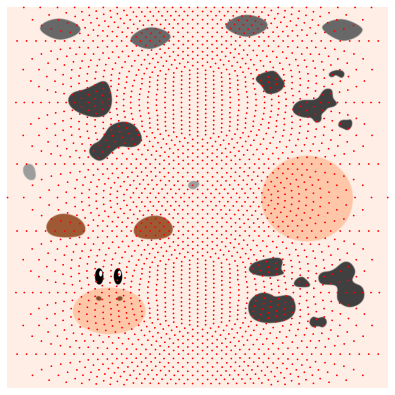

In [18]:
plt.figure(figsize=(7,7))
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=src_mesh.textures.maps_padded()
texturesuv_image_matplotlib(silhouette_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
plt.axis("off");

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

In [19]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

In [20]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 5
# Number of optimization steps
Niter = 1000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = silhouette_src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the silhouettes of the target images:

In [21]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = silhouette_src_mesh.offset_verts(deform_verts)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j].to(device)) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    # if i % plot_period == 0:
    #     visualize_prediction(new_src_mesh, title="iter: %d" % i, silhouette=True,
    #                          target_image=target_silhouette[1])
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
# sum_loss=None
silhouette_result = new_src_mesh.clone().detach()
# visualize_prediction(silhouette_result, silhouette=True, 
#                      target_image=target_silhouette[1], camera=target_cameras[1])
# plot_losses(losses)

## 3. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

In [23]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable 
# Renderer for Image-based 3D Reasoning', ICCV 2019

new_TBN_matrices = tbn_matrices(silhouette_result)

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=imsize, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=NormalSoftPhongShader(device=device, 
        cameras=camera,
        lights=lights,
        tangent_matrices=new_TBN_matrices)
)


We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

In [24]:

# Texture generator Code
class Generator(nn.Module):
    def __init__(self, ngpu, ngf = 32, nc=3, nz=100, type = "normal", conv_layers = 4):
        super(Generator, self).__init__()
        self.type = type
        self.ngpu = ngpu
        self.deconv = nn.Sequential(
            # Testing convoluting target image first 
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Flatten(),
            nn.Linear(ngf * 4 * 16*16, nz),
            UnsqueezeLatent(),
        )
        self.tanh = nn.Tanh()           
        scale_factor = max(4, 4*(2**(4-conv_layers)))
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear')

        if conv_layers < 5:
            self.normal_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 4, 0, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
            self.texture_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 4, 0, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
        else:
            self.normal_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
            self.texture_generator = nn.Sequential(
                nn.ConvTranspose2d(int(ngf * (2**(-2))), nc, 4, 2, 1, bias=False),
                nn.ReLU(True),
                nn.ConvTranspose2d( nc, nc, 3, 1, 1, bias=False),
            )
        if type == "normal":
            self.generator = nn.Sequential(
                # input is Z, going into a convolution
                nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
                # nn.BatchNorm2d(ngf * 8),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*8) x 4 x 4
                nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 4),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*4) x 8 x 8
                nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf * 2),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf*2) x 16 x 16
                nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
                # ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
                # nn.BatchNorm2d(ngf),
                nn.ReLU(True),
                # nn.Dropout2d(p=0.25),
                # state size. (ngf) x 32 x 32
                # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
                # nn.BatchNorm2d(ngf//2),
                # nn.ReLU(True),
                # nn.Dropout2d(),
                # state size. (ngf) x 64 x 64
                nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
                nn.Tanh(),
                # nn.Upsample(scale_factor=4, mode='bilinear')
                # state size. (nc) x 128 x 128
            )
        elif type == "residual":
            self.generator =  nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*8) x 4 x 4
            ResConvTranspose(nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*4) x 8 x 8
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf*2) x 16 x 16
            ResConvTranspose(nn.ConvTranspose2d( ngf, ngf, 4, 2, 1, bias=False),nn.Upsample(scale_factor=2, mode='bilinear')),
            # nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.Dropout2d(p=0.25),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf//2),
            # nn.ReLU(True),
            # nn.Dropout2d(),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 4, 0, bias=False),
            nn.Tanh(),
            # nn.Upsample(scale_factor=4, mode='bilinear')
            # state size. (nc) x 128 x 128
        )
        elif type == "simultaneous":
            modules = [nn.ConvTranspose2d(nz, int(ngf * (2**(conv_layers-2))), 4, 1, 0, bias=False),
                nn.BatchNorm2d(int(ngf * (2**(conv_layers-2)))),
                nn.ReLU(True)]

            # deconv layers that upscale by 2, maximum to 128x128
            for i in range(conv_layers - 2, max(conv_layers - 7, -2), -1):
                modules.extend([
                nn.ConvTranspose2d(int(ngf * (2**(i))), int(ngf * (2**(i-1))), 4, 2, 1, bias=False),
                nn.BatchNorm2d(int(ngf * (2**(i-1)))),
                nn.ReLU(True)
                ])
            # convolution layers without upscaling beyond 128x128 to save on memory
            if conv_layers >= 5:
                for j in range(conv_layers - 7, -2, -1):
                    modules.extend([
                        nn.ConvTranspose2d(int(ngf * (2**(j))), int(ngf * (2**(j-1))), 3, 1, 1, bias=False),
                        nn.BatchNorm2d(int(ngf * (2**(j-1)))),
                        nn.ReLU(True) 
                    ])

            self.generator = nn.Sequential(*modules)
    def forward(self, input):
        if self.type == "simultaneous":
            result = self.generator(input)
            return self.upsampler(self.tanh(self.texture_generator(result))), self.upsampler(self.tanh(self.normal_generator(result)))
        else: 
            return self.generator(input)


In [25]:
# Discriminator code
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf = 32, nc = 3):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout2d(p=0.25),
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            # state size. (ndf*8) x 8 x 8
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [26]:


%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh 
# edge loss, mesh normal consistency, and mesh laplacian smoothing
map_losses = {
          "rgb": {"weight": 1.0, "values": []},
        #   "silhouette": {"weight": 1.0, "values": []},
        #   "edge": {"weight": 1.0, "values": []},
        #   "normal": {"weight": 0.01, "values": []},
        #   "laplacian": {"weight": 1.0, "values": []},
          # "style": {"weight": 1.0, "values": []},
          # "adversarial": {"weight": 0.01, "values": []},
          "smoothness":{"weight":0.1, "values": []},
          "normal_smoothness":{"weight":0.05, "values": []}
         }
losses_gan = {
          "generator": {"weight": 1.0, "values": []},
          "discriminator":{"weight":1.0, "values": []}

}
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in 
# src_mesh
# src_mesh = mesh.clone()
# verts_shape = src_mesh.verts_packed().shape
# deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# verts = src_mesh.verts_packed().to(device)
# .faces_packed().unsqueeze(dim=0).to(device)
faces_uvs = silhouette_result.textures.faces_uvs_padded()
uv_map = silhouette_result.textures.verts_uvs_padded()
# print(uv_map.shape, src_mesh.textures.verts_uvs_padded().shape)
# uv_map.requires_grad = True

# We will also learn per vertex colors for our sphere mesh that define texture 
# of the mesh
# sphere_verts_rgb = torch.full(mesh.textures.maps_padded().shape, 0.1, device=device, requires_grad=True)
# sphere_verts_rgb = torch.normal(mean=torch.full(mesh.textures.maps_padded().shape, 0.5),std=0.05).to(device)
# sphere_verts_rgb.requires_grad = True
# print(sphere_verts_rgb)

# Need to create UV map for the sphere and optimize that together with the texture

# The optimizer
# optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)
# new_src_mesh = src_mesh.clone()
# new_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces, verts_uvs=uv_map)



In [27]:
def evaluate_model(eval_mesh):
    with torch.no_grad():
        # Define the settings for rasterization and shading. Here we set the output 
        # image to be of size 128X128. As we are rendering images for visualization 
        # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
        # rasterize_meshes.py for explanations of these parameters.  We also leave 
        # bin_size and max_faces_per_bin to their default values of None, which sets 
        # their values using heuristics and ensures that the faster coarse-to-fine 
        # rasterization method is used.  Refer to docs/notes/renderer.md for an 
        # explanation of the difference between naive and coarse-to-fine rasterization. 
        raster_settings = RasterizationSettings(
            image_size=imsize, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            perspective_correct=False,
        )
        # Create a Phong renderer by composing a rasterizer and a shader. The textured 
        # Phong shader will interpolate the texture uv coordinates for each vertex, 
        # sample from a texture image and apply the Phong lighting model
        renderer = NormalMeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=camera, 
                raster_settings=raster_settings
            ),
            shader=NormalSoftPhongShader(
                device=device, 
                cameras=test_cameras,
                lights=lights,
                tangent_matrices=new_TBN_matrices,
            )
        )
        test_cos_sim = torch.nn.CosineSimilarity(dim=4)
        normals_similarity = 0
        image_MSE = 0
        # Calculate RGB loss for each view point in test set
        for j in range(len(test_cameras)):
            image_predicted, normals_predicted = renderer(eval_mesh, cameras=test_cameras[j], lights=lights,)

            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = image_predicted[..., :3]
            predicted_rgb.squeeze()
            image_MSE += ((predicted_rgb - test_rgb[j].to(device)) ** 2).mean()
            normals_similarity += test_cos_sim(test_normals[j], normals_predicted).mean()
        mean_MSE = image_MSE / len(test_cameras)
        normals_similarity = normals_similarity / len(test_cameras)
        # visualize_prediction(eval_mesh, renderer=renderer, camera=test_cameras[1], silhouette=False,target_image = test_rgb[1])

        return mean_MSE, normals_similarity
    # print(mean_MSE)

# print(evaluate_model())

In [28]:
class ResConvTranspose(nn.Module):
    layer = 0
    def __init__(self, deconv, upsampler):
        super().__init__()
        self.module = deconv
        self.upsampler = upsampler
        self.weight = torch.nn.Parameter(deconv.weight)

    def forward(self, inputs):
        return self.module(inputs) + self.upsampler(inputs)

class UnsqueezeLatent(nn.Module):
    layer = 0
    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        return torch.unsqueeze(torch.unsqueeze(inputs, 2), 3)

In [29]:
import torch.utils.data
# from torchsummary import summary

def train_network(config):
    # Number of views to optimize over in each SGD iteration
    # print("Starting training")
    num_views_per_iteration = min(1, num_views)
    # Number of optimization steps
    Niter = 1500
    # Plot period for the losses
    plot_period = Niter // 5

    loop = tqdm(range(Niter))
    # maps = [sphere_verts_rgb.detach().cpu()]


    # Adversarial loss from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    nc = 3
    # ndf = 32
    ngf = config["ngf"]
    nz = config["nz"]
    layers = config["layers"]
    lr = config["lr"]
    beta1 = config["beta1"]
    beta2 = config["beta2"]
    l2penalty = config["l2"]
    amsgrad = config["amsgrad"]
    # print("Upacked parameters")


    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.05)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.05)
            nn.init.constant_(m.bias.data, 0)


    # Create discriminator for adversarial loss
    ngpu = 1
    # workers = 2
    # bce_loss = nn.BCELoss()
    # netD = Discriminator(ngpu, ndf).to(device)
    # netD.apply(weights_init)
    # real_label = 1.
    # fake_label = 0.
    # optimizerD = torch.optim.SGD(netD.parameters(), lr=lr)


    # Create the generator
    netG = Generator(ngpu, ngf, nc, nz, "simultaneous", layers).to(device)
    # summary(netG, (nz, 1, 1))
    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.02.
    netG.apply(weights_init)

    # Need to create UV map for the sphere and optimize that together with the texture
    # The optimizer
    # maps_src_mesh.textures = TexturesUV(sphere_verts_rgb, faces_uvs=faces_uvs, verts_uvs=uv_map)

    # Need to create UV map for the sphere and optimize that together with the texture
    scale_factor = 1
    texture_size = list(mesh.textures.maps_padded().shape)
    texture_size[1] //= scale_factor
    texture_size[2] //= scale_factor

    # print("Texture Size: {}".format(texture_size))
    # sphere_verts_rgb = torch.zeros(texture_size, device=device, requires_grad=True)
    # optimizer = torch.optim.Adam([sphere_verts_rgb], lr=0.001)

    # sphere_verts_rgb = src_mesh.textures.maps_padded()
    # sphere_verts_rgb.requires_grad = True
    # The optimizer
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=l2penalty, amsgrad=amsgrad)
    random_vector = torch.randn(1, nz, 1, 1, device=device) * 0.5
    # print(random_vector.shape)
    # print(random_vector.shape)
    # sphere_verts_rgb = netG(target_rgb[0].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1)
    sphere_verts_rgb, normal_map_base = netG(random_vector)
    # print(sphere_verts_rgb.shape, normal_map_base.shape)
    zero_dims = texture_size[:3]
    zero_dims.append(2)
    ones_dims = texture_size[:3]
    ones_dims.append(1)
    # begin with a flat normal map and just offset it using the generator by a small amount
    normal_map_flat = torch.cat([torch.ones(zero_dims).to(device)*0.5, torch.ones(ones_dims).to(device)], dim=3)
    # normal_map_base.requires_grad = True
    # optimizerNorm = torch.optim.Adam([normal_map_base], lr=lr, betas=(beta1, 0.999))


    maps_src_mesh = silhouette_result.clone()
    maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
    maps_src_mesh.normalmaps = TexturesUV(normal_map_flat, faces_uvs=faces_uvs, verts_uvs=uv_map)
    # print(maps_src_mesh.normalmaps.maps_padded().shape)

    # Cosine similarity loss for normal map
    cos_similarity = torch.nn.CosineSimilarity(dim=3)

    # print("Initialized state")


    # period to evaluate mesh against test views with normal rasterization
    eval_period = 20
    # mse_iters = []
    # cos_sims = []
    for i in loop:
        transform_range_horizontal = 5/sphere_verts_rgb.shape[2]
        transform_range_vertical = 5/sphere_verts_rgb.shape[3]
        transform = RandomAffine(0, translate=(transform_range_horizontal,transform_range_vertical))
        # Initialize optimizer
        optimizerG.zero_grad()
        
        # Deform the mesh
        # maps_src_mesh = src_mesh.offset_verts(deform_verts)
        
        # Add per vertex colors to texture the mesh
        # TODO create UV map for faces and vertices for the default sphere

        # sphere_verts_rgb = netG(target_rgb[i % len(target_rgb)].to(device).unsqueeze(0).permute(0,3,1,2)).permute(0,2,3,1) #- for generator network
        sphere_verts_rgb, normal_map_base = netG(random_vector)
        maps_src_mesh.textures = TexturesUV(sphere_verts_rgb.permute(0,2,3,1), faces_uvs=faces_uvs, verts_uvs=uv_map)
        new_normal_map = normal_map_base.permute(0,2,3,1) * 0.25 + normal_map_flat
        # new_normal_map = normal_map_flat
        maps_src_mesh.normalmaps = TexturesUV(new_normal_map, faces_uvs=faces_uvs, verts_uvs=uv_map)

        # Losses to smooth /regularize the mesh shape
        map_loss = {k: torch.tensor(0.0, device=device) for k in map_losses}
        # update_mesh_shape_prior_losses(maps_src_mesh, loss)
        # loss_gan = {k: torch.tensor(0.0, device=device) for k in losses_gan}

        # Randomly select two views to optimize over in this iteration.  Compared
        # to using just one view, this helps resolve ambiguities between updating
        # mesh shape vs. updating mesh texture
        rendered_rgb = []

        # Getting examples from renderer as the Generator
        random_views = np.random.permutation(len(target_cameras)).tolist()[:num_views_per_iteration]
        for j in random_views:
            images_predicted, _ = renderer_textured(maps_src_mesh, cameras=target_cameras[j], lights=lights)

            # Squared L2 distance between the predicted silhouette and the target 
            # # silhouette from our dataset
            # predicted_silhouette = images_predicted[..., 3]
            # loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
            # loss["silhouette"] += loss_silhouette / num_views_per_iteration
            
            # Squared L2 distance between the predicted RGB image and the target 
            predicted_rgb = images_predicted[..., :3]
            rendered_rgb.append(predicted_rgb.squeeze())
            loss_rgb = ((predicted_rgb - target_rgb[j].to(device)) ** 2).mean()

            # Style loss WIP
            # target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0)
            # model, style_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, target_rgb[j].clone().detach().permute(2,0,1).unsqueeze(0))
            # model_input = sphere_verts_rgb.clone().detach().to(device).permute(0,3,1,2)
            # model(model_input)
            # style_score = 0
            # for sl in style_losses:
            #     style_score += sl.loss

            # Shifted image to get the image to be smoother/gradient between pixels to be smoother
            smoothness = ((sphere_verts_rgb - transform(sphere_verts_rgb))**2).mean()
            normal_smoothness = ((normal_map_flat - new_normal_map)**2).mean()
            # print(normal_smoothness)

            map_loss["rgb"] += loss_rgb / num_views_per_iteration
            map_loss["smoothness"] += smoothness / num_views_per_iteration
            map_loss["normal_smoothness"] += normal_smoothness / num_views_per_iteration
            # loss["style"] += style_score / num_views_per_iteration

        # ############################
        # # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # ###########################
        # ## Train with all-real batch
        # netD.zero_grad()
        # # Format batch
        # real_cpu = torch.stack([target_rgb[i].to(device) for i in random_views], dim=0).permute(0,3,1,2)
        # real_cpu = real_cpu + torch.randn(real_cpu.size(), device=device)*0.1
        # b_size = num_views_per_iteration
        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # # Forward pass real batch through D
        # output = netD(real_cpu).view(-1)
        # # Calculate loss on all-real batch
        # errD_real = bce_loss(output, label)
        # # Calculate gradients for D in backward pass
        # errD_real.backward()
        # # D_x = output.mean().item()

        # ## Train with all-fake batch
        # # Generate batch of latent vectors
        # # Generate fake image batch with G
        # fake = torch.stack(rendered_rgb, dim=0).permute(0,3,1,2) + torch.randn(real_cpu.size(), device=device)*0.1
        # label.fill_(fake_label)
        # # Classify all fake batch with D
        # output = netD(fake).view(-1)
        # # Calculate D's loss on the all-fake batch
        # errD_fake = bce_loss(output, label)
        # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        # errD_fake.backward(retain_graph=True)
        # # D_G_z1 = output.mean().item()
        # # Compute error of D as sum over the fake and the real batches
        # errD = errD_real + errD_fake
        # # Update D
        # optimizerD.step()

        # ############################
        # # (2) Update G network: maximize log(D(G(z)))
        # ###########################
        # label.fill_(real_label)  # fake labels are real for generator cost
        # # Since we just updated D, perform another forward pass of all-fake batch through D
        # output = netD(fake).view(-1)
        # # Calculate G's loss based on this output
        # errG = bce_loss(output, label)
        # # Calculate gradients for G
        # # D_G_z2 = output.mean().item()
        # # Update G

        # loss["adversarial"] = errG / num_views_per_iteration
        # loss_gan["generator"] = errG / num_views_per_iteration
        # loss_gan["discriminator"] = errD / num_views_per_iteration / 2

        # Weighted sum of the losses
        map_sum_loss = torch.tensor(0.0, device=device)
        for k, l in map_loss.items():
            map_sum_loss += l * map_losses[k]["weight"]
            map_losses[k]["values"].append(float(l.detach().cpu()))
        loop.set_description("total_loss = %.6f" % map_sum_loss)


        # for k, l in loss_gan.items():
            # losses_gan[k]["values"].append(float(l.detach().cpu()))
        # Print the losses
        
        # Plot mesh
        # if i % plot_period == 0:
        #     visualize_prediction(maps_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
            # maps.append(sphere_verts_rgb.detach().cpu())

        # Optimization step
        map_sum_loss.backward()
        optimizerG.step()

        
        if i % eval_period == 0:
            mse, cos_sim = evaluate_model(maps_src_mesh)
            # mse_iters.append(mse)
            # cos_sims.append(cos_sim)
            
        # Train Discriminator
        # I want to make a generator that will create patches from the texture and warp them somehow to simulate them being on a surface. I'm thinking of some gradient mask too so that we don't learn from empty space. 
        # The true examples would be patches from the real image (probably also good to make it so that the object makes up at least some proportion of the patch for it to be accepted)

        # Train Texture/Generator
        # Here I want to use the discriminator to learn the texture better to try and fool it with the renderer serving as generator and the texture being the parameters we are tweaking/learning. 
    # print("Finished training")
    mse, cos_sim = evaluate_model(maps_src_mesh)
    return mse



In [30]:
def objective(trial):

    params = {

                "ngf": trial.suggest_categorical('ngf', [16,32,64]),
                "nz": trial.suggest_int("nz", 10, 200),
                "layers": trial.suggest_int("layers", 1,7),
                "lr": trial.suggest_loguniform('lr', 1e-5, 1e-1),
                "beta1": trial.suggest_uniform('beta1', 0.2, 0.9),
                "beta2": trial.suggest_loguniform('beta2', 0.9, 0.9999),
                "l2": trial.suggest_loguniform('l2', 1e-6, 1e-2),
                "amsgrad": True,
            }
    
    
    loss = train_network(params)

    return loss

In [85]:

# config = {
#     "ngf": tune.choice([16, 32, 64]),

# #     "nz": 100,
# #     "layers": tune.choice([2,3,4,5]),
# #     "lr": tune.loguniform(1e-5, 1e-1),
# #     "beta1": tune.uniform(0.2, 0.9),
# #     "beta2": 0.999,
# #     "l2": tune.loguniform(1e-6, 1e-2),
# #     "amsgrad": True,
#     "nz": 100,
#     "layers": 5,
#     "lr": 0.001,
#     "beta1": 0.5,
#     "beta2": 0.999,
#     "l2": 0,
#     "amsgrad": False,
# }
# scheduler = ASHAScheduler(
#         metric="loss",
#         mode="min",
#         time_attr="training_iteration",
#         max_t=1000,
#         grace_period=1,
#         reduction_factor=2
#         )

# reporter = JupyterNotebookReporter(True,
#         metric_columns=["loss", "training_iteration"]
#         )


In [86]:
# custom_config = {
#     "ngf": 64,
#     "nz": 100,
#     "layers": 5,
#     "lr": 0.001,
#     "beta1": 0.5,
#     "beta2": 0.999,
#     "l2": 0,
#     "amsgrad": True,
# }
# train_network(custom_config)


In [31]:
# optuna optimization created following https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2022-03-28 12:31:00,751] A new study created in memory with name: no-name-8efcd08f-ee61-4aa1-866d-733f9211f911


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:33:07,764] Trial 0 finished with value: 0.003296546870842576 and parameters: {'ngf': 64, 'nz': 63, 'layers': 2, 'lr': 0.00034275061007206764, 'beta1': 0.5641676435954996, 'beta2': 0.9263047054026364, 'l2': 2.6401135364345252e-05}. Best is trial 0 with value: 0.003296546870842576.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:35:13,205] Trial 1 finished with value: 0.014186839573085308 and parameters: {'ngf': 32, 'nz': 97, 'layers': 6, 'lr': 1.1096439198609474e-05, 'beta1': 0.49810512404765134, 'beta2': 0.9511787750034093, 'l2': 0.00058194219365208}. Best is trial 0 with value: 0.003296546870842576.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:37:19,909] Trial 2 finished with value: 0.003328382968902588 and parameters: {'ngf': 32, 'nz': 129, 'layers': 2, 'lr': 0.0005172146421066737, 'beta1': 0.5668128997778559, 'beta2': 0.9409476672247746, 'l2': 1.5402959272837764e-06}. Best is trial 0 with value: 0.003296546870842576.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:39:21,191] Trial 3 finished with value: 0.003387733828276396 and parameters: {'ngf': 16, 'nz': 56, 'layers': 3, 'lr': 0.01623507485062631, 'beta1': 0.6897217198610255, 'beta2': 0.9174912470868033, 'l2': 0.0006463390424442149}. Best is trial 0 with value: 0.003296546870842576.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:41:23,375] Trial 4 finished with value: 0.018376944586634636 and parameters: {'ngf': 32, 'nz': 22, 'layers': 3, 'lr': 2.4059846353153842e-05, 'beta1': 0.3601567661860403, 'beta2': 0.9224325049615687, 'l2': 0.00016381742606270182}. Best is trial 0 with value: 0.003296546870842576.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:43:32,749] Trial 5 finished with value: 0.0031809292268007994 and parameters: {'ngf': 32, 'nz': 50, 'layers': 2, 'lr': 0.04390224897853059, 'beta1': 0.8408238966874, 'beta2': 0.9919467045698261, 'l2': 2.103151221724845e-06}. Best is trial 5 with value: 0.0031809292268007994.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:45:36,598] Trial 6 finished with value: 0.0033983939792960882 and parameters: {'ngf': 16, 'nz': 174, 'layers': 6, 'lr': 0.017415277532091916, 'beta1': 0.7766936763834433, 'beta2': 0.9422351386608092, 'l2': 0.0007209157809342306}. Best is trial 5 with value: 0.0031809292268007994.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:47:37,376] Trial 7 finished with value: 0.010726194828748703 and parameters: {'ngf': 16, 'nz': 160, 'layers': 5, 'lr': 2.418452341540476e-05, 'beta1': 0.25514741661743073, 'beta2': 0.9508283902995652, 'l2': 0.0017614968577593462}. Best is trial 5 with value: 0.0031809292268007994.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:49:39,274] Trial 8 finished with value: 0.003190858056768775 and parameters: {'ngf': 64, 'nz': 156, 'layers': 3, 'lr': 0.000608208850654448, 'beta1': 0.8957378782262495, 'beta2': 0.9540339213083623, 'l2': 6.298725803219573e-06}. Best is trial 5 with value: 0.0031809292268007994.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:51:39,579] Trial 9 finished with value: 0.022609153762459755 and parameters: {'ngf': 64, 'nz': 112, 'layers': 4, 'lr': 1.2846847598713245e-05, 'beta1': 0.4978223727310294, 'beta2': 0.9000930587052934, 'l2': 0.004834850074034821}. Best is trial 5 with value: 0.0031809292268007994.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:53:38,871] Trial 10 finished with value: 0.0038097158540040255 and parameters: {'ngf': 32, 'nz': 20, 'layers': 4, 'lr': 0.09368554413252826, 'beta1': 0.8760691177816156, 'beta2': 0.9985665162211307, 'l2': 1.2420847490262917e-06}. Best is trial 5 with value: 0.0031809292268007994.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:55:39,827] Trial 11 finished with value: 0.003107657190412283 and parameters: {'ngf': 64, 'nz': 146, 'layers': 3, 'lr': 0.0026958899543913914, 'beta1': 0.8776871431640113, 'beta2': 0.9857196940004833, 'l2': 7.76192947610013e-06}. Best is trial 11 with value: 0.003107657190412283.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:57:48,507] Trial 12 finished with value: 0.003040011739358306 and parameters: {'ngf': 64, 'nz': 195, 'layers': 2, 'lr': 0.004361955698126581, 'beta1': 0.7348386561733672, 'beta2': 0.9953238051214539, 'l2': 1.1748513849331835e-05}. Best is trial 12 with value: 0.003040011739358306.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 12:59:54,361] Trial 13 finished with value: 0.003024704521521926 and parameters: {'ngf': 64, 'nz': 194, 'layers': 3, 'lr': 0.0024779614985461834, 'beta1': 0.7070565235002179, 'beta2': 0.9761506085475053, 'l2': 2.317770994227827e-05}. Best is trial 13 with value: 0.003024704521521926.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:02:03,783] Trial 14 finished with value: 0.003145871451124549 and parameters: {'ngf': 64, 'nz': 191, 'layers': 2, 'lr': 0.00288769723803011, 'beta1': 0.7049793786778421, 'beta2': 0.9737480136449393, 'l2': 5.200115453721242e-05}. Best is trial 13 with value: 0.003024704521521926.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:04:08,108] Trial 15 finished with value: 0.0031434709671884775 and parameters: {'ngf': 64, 'nz': 190, 'layers': 3, 'lr': 0.0033300380761385347, 'beta1': 0.6725315362682149, 'beta2': 0.9700773757939773, 'l2': 1.633109944210145e-05}. Best is trial 13 with value: 0.003024704521521926.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:06:10,985] Trial 16 finished with value: 0.0030307744164019823 and parameters: {'ngf': 64, 'nz': 174, 'layers': 4, 'lr': 0.00015682480915887837, 'beta1': 0.7662336700559094, 'beta2': 0.9742830497564167, 'l2': 0.000112756045921538}. Best is trial 13 with value: 0.003024704521521926.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:08:17,685] Trial 17 finished with value: 0.0028049664106220007 and parameters: {'ngf': 64, 'nz': 137, 'layers': 5, 'lr': 0.00010658230336363386, 'beta1': 0.6158624342578893, 'beta2': 0.9745218994536383, 'l2': 0.00010847311592052035}. Best is trial 17 with value: 0.0028049664106220007.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:10:22,422] Trial 18 finished with value: 0.0027171033434569836 and parameters: {'ngf': 64, 'nz': 98, 'layers': 5, 'lr': 0.0001071801176916571, 'beta1': 0.6026271362216988, 'beta2': 0.9672847663711883, 'l2': 0.00024195198452913935}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:12:30,177] Trial 19 finished with value: 0.003070726990699768 and parameters: {'ngf': 64, 'nz': 88, 'layers': 5, 'lr': 7.27365785953858e-05, 'beta1': 0.6241500130893647, 'beta2': 0.9623159402899899, 'l2': 0.00022034037831793543}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:14:33,551] Trial 20 finished with value: 0.004707153420895338 and parameters: {'ngf': 16, 'nz': 135, 'layers': 5, 'lr': 8.931905516918204e-05, 'beta1': 0.3674223444950513, 'beta2': 0.9628174896574523, 'l2': 6.023716303248317e-05}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:16:27,227] Trial 21 finished with value: 0.0030950859654694796 and parameters: {'ngf': 64, 'nz': 116, 'layers': 5, 'lr': 0.0012608975095606241, 'beta1': 0.6302298825471897, 'beta2': 0.9802254086598378, 'l2': 0.00032246390196609664}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:18:23,188] Trial 22 finished with value: 0.0028790722135454416 and parameters: {'ngf': 64, 'nz': 80, 'layers': 6, 'lr': 0.0001980933347419562, 'beta1': 0.49210828033458953, 'beta2': 0.9635660488580272, 'l2': 3.916162649127112e-05}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:20:20,425] Trial 23 finished with value: 0.0029677734710276127 and parameters: {'ngf': 64, 'nz': 84, 'layers': 6, 'lr': 0.00019674446743489334, 'beta1': 0.43673773106730984, 'beta2': 0.9601501303196062, 'l2': 7.664554599532742e-05}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:22:15,901] Trial 24 finished with value: 0.0029021098744124174 and parameters: {'ngf': 64, 'nz': 69, 'layers': 6, 'lr': 7.471067537328378e-05, 'beta1': 0.5023612163893696, 'beta2': 0.9664360307036043, 'l2': 0.0017873690897289342}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:24:08,208] Trial 25 finished with value: 0.0032947701402008533 and parameters: {'ngf': 64, 'nz': 122, 'layers': 5, 'lr': 3.8032482233043134e-05, 'beta1': 0.4151703775206346, 'beta2': 0.9861562195607071, 'l2': 4.1716118509576506e-05}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:26:03,758] Trial 26 finished with value: 0.002952311420813203 and parameters: {'ngf': 64, 'nz': 102, 'layers': 6, 'lr': 0.00023414632421402522, 'beta1': 0.6039212703550428, 'beta2': 0.9350240942788175, 'l2': 0.0002905091010638939}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:27:53,018] Trial 27 finished with value: 0.002914290176704526 and parameters: {'ngf': 64, 'nz': 38, 'layers': 5, 'lr': 0.00011780042063365459, 'beta1': 0.2692979395316929, 'beta2': 0.9560199455216389, 'l2': 3.467778897357085e-06}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:29:39,144] Trial 28 finished with value: 0.012918324209749699 and parameters: {'ngf': 16, 'nz': 79, 'layers': 4, 'lr': 4.0742154503999584e-05, 'beta1': 0.4550071519744036, 'beta2': 0.9823355773490058, 'l2': 0.00010962235129559128}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:31:33,583] Trial 29 finished with value: 0.002960614860057831 and parameters: {'ngf': 64, 'nz': 73, 'layers': 6, 'lr': 0.0003925063039038092, 'beta1': 0.5515996856143769, 'beta2': 0.9420305363965666, 'l2': 3.202219167645288e-05}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:33:23,314] Trial 30 finished with value: 0.0029688214417546988 and parameters: {'ngf': 64, 'nz': 140, 'layers': 5, 'lr': 0.0010539354608974077, 'beta1': 0.5772306508766958, 'beta2': 0.9683202193294203, 'l2': 0.001522255745740033}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:35:17,644] Trial 31 finished with value: 0.003063093638047576 and parameters: {'ngf': 64, 'nz': 67, 'layers': 6, 'lr': 5.7128468225765424e-05, 'beta1': 0.5103669656877863, 'beta2': 0.9663658742253445, 'l2': 0.008796611400928028}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:37:11,878] Trial 32 finished with value: 0.0027807268779724836 and parameters: {'ngf': 64, 'nz': 87, 'layers': 6, 'lr': 0.0002517615765506084, 'beta1': 0.512732092244284, 'beta2': 0.9574198130769118, 'l2': 0.0020075753964849596}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:39:07,042] Trial 33 finished with value: 0.00276244361884892 and parameters: {'ngf': 64, 'nz': 95, 'layers': 6, 'lr': 0.00030168236862323215, 'beta1': 0.6441772415673584, 'beta2': 0.9462033784395127, 'l2': 0.0033942091899232907}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:40:56,088] Trial 34 finished with value: 0.0027467969339340925 and parameters: {'ngf': 32, 'nz': 94, 'layers': 6, 'lr': 0.0006841764427693649, 'beta1': 0.6211179278780706, 'beta2': 0.9467627188128653, 'l2': 0.0033226946340972185}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:42:45,212] Trial 35 finished with value: 0.0028134777676314116 and parameters: {'ngf': 32, 'nz': 95, 'layers': 6, 'lr': 0.0007850628627021943, 'beta1': 0.648381572158983, 'beta2': 0.933626524970856, 'l2': 0.003987331819583577}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:44:34,522] Trial 36 finished with value: 0.0029514124616980553 and parameters: {'ngf': 32, 'nz': 104, 'layers': 6, 'lr': 0.000331066097907164, 'beta1': 0.5745330662957282, 'beta2': 0.9450824680657749, 'l2': 0.0010609403611644495}. Best is trial 18 with value: 0.0027171033434569836.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:46:23,570] Trial 37 finished with value: 0.0026620356366038322 and parameters: {'ngf': 32, 'nz': 56, 'layers': 6, 'lr': 0.0004156275145257254, 'beta1': 0.5410549917527033, 'beta2': 0.9472509651417371, 'l2': 0.003423058857338013}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:48:12,860] Trial 38 finished with value: 0.0028169360011816025 and parameters: {'ngf': 32, 'nz': 51, 'layers': 6, 'lr': 0.0004940393210322767, 'beta1': 0.6620766756923716, 'beta2': 0.9349866451332354, 'l2': 0.003707828110019805}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:49:59,096] Trial 39 finished with value: 0.0032377864699810743 and parameters: {'ngf': 32, 'nz': 32, 'layers': 5, 'lr': 0.006356700791425941, 'beta1': 0.7933634076959674, 'beta2': 0.9167750708899446, 'l2': 0.006693823243014789}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:51:47,854] Trial 40 finished with value: 0.00291583314538002 and parameters: {'ngf': 32, 'nz': 60, 'layers': 6, 'lr': 0.0014593151896146361, 'beta1': 0.5375081167838821, 'beta2': 0.9482675019741263, 'l2': 0.0004596751069414731}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:53:36,943] Trial 41 finished with value: 0.002749920357018709 and parameters: {'ngf': 32, 'nz': 93, 'layers': 6, 'lr': 0.00033100081950143364, 'beta1': 0.5360084982067274, 'beta2': 0.9483012433120633, 'l2': 0.0025669463990784566}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:55:25,641] Trial 42 finished with value: 0.002807936631143093 and parameters: {'ngf': 32, 'nz': 10, 'layers': 6, 'lr': 0.0007009054164002313, 'beta1': 0.5994240138137131, 'beta2': 0.94882496042295, 'l2': 0.0027780705157310274}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:57:14,600] Trial 43 finished with value: 0.0028295714873820543 and parameters: {'ngf': 32, 'nz': 113, 'layers': 6, 'lr': 0.0005241061884922657, 'beta1': 0.5447443235324979, 'beta2': 0.9261636197679464, 'l2': 0.0008920918473753481}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 13:59:01,603] Trial 44 finished with value: 0.0030490525532513857 and parameters: {'ngf': 32, 'nz': 125, 'layers': 5, 'lr': 0.0016039268406930157, 'beta1': 0.7396473451382406, 'beta2': 0.9369923315942272, 'l2': 0.006991772890465876}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:00:50,670] Trial 45 finished with value: 0.0029134328942745924 and parameters: {'ngf': 32, 'nz': 94, 'layers': 6, 'lr': 0.0003366890385605208, 'beta1': 0.4581406009596839, 'beta2': 0.9523484728760487, 'l2': 0.0031486851615160814}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:02:39,915] Trial 46 finished with value: 0.0029881191439926624 and parameters: {'ngf': 32, 'nz': 106, 'layers': 6, 'lr': 0.0008933435698255867, 'beta1': 0.5767685207260432, 'beta2': 0.9398159515342897, 'l2': 0.0012628730188014756}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:04:24,019] Trial 47 finished with value: 0.004904674366116524 and parameters: {'ngf': 32, 'nz': 39, 'layers': 4, 'lr': 0.00013374392872578478, 'beta1': 0.6728268875634417, 'beta2': 0.9466137026178113, 'l2': 0.0005812659148483455}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:06:08,800] Trial 48 finished with value: 0.018075961619615555 and parameters: {'ngf': 16, 'nz': 55, 'layers': 5, 'lr': 1.9819680445001954e-05, 'beta1': 0.6508433105527851, 'beta2': 0.9524185424750977, 'l2': 0.002373797363487018}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:07:58,040] Trial 49 finished with value: 0.0035011719446629286 and parameters: {'ngf': 32, 'nz': 94, 'layers': 6, 'lr': 0.0019308239329878247, 'beta1': 0.7057419286352282, 'beta2': 0.9439474263151408, 'l2': 0.005686408941483663}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:09:44,750] Trial 50 finished with value: 0.00275845592841506 and parameters: {'ngf': 32, 'nz': 78, 'layers': 5, 'lr': 0.00030977190894160457, 'beta1': 0.379825259580552, 'beta2': 0.9300409150631231, 'l2': 0.004788437782941035}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:11:30,542] Trial 51 finished with value: 0.003002178156748414 and parameters: {'ngf': 32, 'nz': 74, 'layers': 5, 'lr': 0.00030999093007176234, 'beta1': 0.37820895327428006, 'beta2': 0.9280641022006747, 'l2': 0.00993203226237008}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:13:15,082] Trial 52 finished with value: 0.003555990057066083 and parameters: {'ngf': 32, 'nz': 101, 'layers': 4, 'lr': 0.0004685856890806729, 'beta1': 0.3164882238963218, 'beta2': 0.9575623319008282, 'l2': 0.0047921563539210605}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:15:04,111] Trial 53 finished with value: 0.002797669032588601 and parameters: {'ngf': 32, 'nz': 90, 'layers': 6, 'lr': 0.00017873788643061377, 'beta1': 0.20354537520680527, 'beta2': 0.9121236427379306, 'l2': 0.002936155473665496}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:16:50,264] Trial 54 finished with value: 0.0028641826938837767 and parameters: {'ngf': 32, 'nz': 111, 'layers': 5, 'lr': 0.0006427294880760846, 'beta1': 0.39762289482651897, 'beta2': 0.9303094600764259, 'l2': 0.0008220205910847185}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:18:40,088] Trial 55 finished with value: 0.00269891694188118 and parameters: {'ngf': 32, 'nz': 78, 'layers': 6, 'lr': 0.00014232754365773266, 'beta1': 0.33309070060241996, 'beta2': 0.9393236314208712, 'l2': 0.0014295143294686967}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:20:26,371] Trial 56 finished with value: 0.00623682327568531 and parameters: {'ngf': 32, 'nz': 46, 'layers': 5, 'lr': 5.109548502695735e-05, 'beta1': 0.33921938036070276, 'beta2': 0.9383496073358797, 'l2': 0.0013324472001036117}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:22:11,321] Trial 57 finished with value: 0.005243586841970682 and parameters: {'ngf': 32, 'nz': 62, 'layers': 4, 'lr': 0.00014392159360253877, 'beta1': 0.30982197739558553, 'beta2': 0.9234694083299573, 'l2': 0.0022347594735641035}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:24:00,432] Trial 58 finished with value: 0.0028521057683974504 and parameters: {'ngf': 32, 'nz': 78, 'layers': 6, 'lr': 9.740450689488198e-05, 'beta1': 0.47161265417294307, 'beta2': 0.931163783537031, 'l2': 0.00017156350045063}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:25:49,687] Trial 59 finished with value: 0.0029868348501622677 and parameters: {'ngf': 32, 'nz': 85, 'layers': 6, 'lr': 0.00021898880018260202, 'beta1': 0.24109060493849194, 'beta2': 0.9180853660831032, 'l2': 0.00048368804896399906}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:27:35,901] Trial 60 finished with value: 0.0029359101317822933 and parameters: {'ngf': 32, 'nz': 68, 'layers': 5, 'lr': 0.0010202637993062724, 'beta1': 0.4087316806621259, 'beta2': 0.9507981766284866, 'l2': 0.005006107357787013}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:29:23,723] Trial 61 finished with value: 0.002750119660049677 and parameters: {'ngf': 16, 'nz': 119, 'layers': 6, 'lr': 0.0002628179625175737, 'beta1': 0.529756012438065, 'beta2': 0.9429373860158676, 'l2': 0.003482121297183819}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:31:10,220] Trial 62 finished with value: 0.002760121366009116 and parameters: {'ngf': 16, 'nz': 108, 'layers': 6, 'lr': 0.000434792203096391, 'beta1': 0.29153035637945235, 'beta2': 0.9402009793394769, 'l2': 0.0017988343103909007}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:32:56,568] Trial 63 finished with value: 0.0031593204475939274 and parameters: {'ngf': 16, 'nz': 117, 'layers': 6, 'lr': 0.00024417420356140227, 'beta1': 0.5294668440471636, 'beta2': 0.9413631584523676, 'l2': 0.007731143937581579}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:34:43,158] Trial 64 finished with value: 0.005814182106405497 and parameters: {'ngf': 16, 'nz': 132, 'layers': 6, 'lr': 7.426346601345287e-05, 'beta1': 0.4756770940446717, 'beta2': 0.9549483688794276, 'l2': 0.004252430796346806}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:36:29,420] Trial 65 finished with value: 0.0028271202463656664 and parameters: {'ngf': 16, 'nz': 119, 'layers': 6, 'lr': 0.00011465961428428609, 'beta1': 0.5924852866233128, 'beta2': 0.9488087239860309, 'l2': 0.0011255031383576417}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:38:16,352] Trial 66 finished with value: 0.002819292712956667 and parameters: {'ngf': 16, 'nz': 79, 'layers': 6, 'lr': 0.00015282358176341247, 'beta1': 0.42819621480024017, 'beta2': 0.9435495038927586, 'l2': 0.002401832146210562}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:40:03,546] Trial 67 finished with value: 0.002855384722352028 and parameters: {'ngf': 32, 'nz': 127, 'layers': 5, 'lr': 0.0006155505016454978, 'beta1': 0.5203029786368513, 'beta2': 0.9366466129519208, 'l2': 0.006074434848162054}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:41:52,854] Trial 68 finished with value: 0.00868307612836361 and parameters: {'ngf': 32, 'nz': 73, 'layers': 6, 'lr': 3.469215819679776e-05, 'beta1': 0.557406606785833, 'beta2': 0.933183190624971, 'l2': 0.0016663290794915377}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:43:39,526] Trial 69 finished with value: 0.0028747643809765577 and parameters: {'ngf': 16, 'nz': 100, 'layers': 6, 'lr': 0.0002750745350145002, 'beta1': 0.6151500024040804, 'beta2': 0.9582286256943476, 'l2': 0.0007152712293441095}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:45:25,702] Trial 70 finished with value: 0.0028716789092868567 and parameters: {'ngf': 32, 'nz': 85, 'layers': 5, 'lr': 0.00038006029184982186, 'beta1': 0.3552965809099412, 'beta2': 0.9539422168981115, 'l2': 0.0003387671923744931}. Best is trial 37 with value: 0.0026620356366038322.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:47:12,277] Trial 71 finished with value: 0.002642750972881913 and parameters: {'ngf': 16, 'nz': 151, 'layers': 6, 'lr': 0.00045192862258474264, 'beta1': 0.3287530107872564, 'beta2': 0.9403691820329341, 'l2': 0.00183485394442805}. Best is trial 71 with value: 0.002642750972881913.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:48:59,660] Trial 72 finished with value: 0.0028543747030198574 and parameters: {'ngf': 16, 'nz': 156, 'layers': 6, 'lr': 0.0001905886540163579, 'beta1': 0.38101372651317167, 'beta2': 0.942661334054237, 'l2': 0.00347628862648892}. Best is trial 71 with value: 0.002642750972881913.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:50:45,953] Trial 73 finished with value: 0.002605059649795294 and parameters: {'ngf': 16, 'nz': 149, 'layers': 6, 'lr': 0.000390652649743842, 'beta1': 0.33784723988355825, 'beta2': 0.9378792680516778, 'l2': 0.002352535089280613}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:52:32,334] Trial 74 finished with value: 0.004343060310930014 and parameters: {'ngf': 16, 'nz': 147, 'layers': 6, 'lr': 0.04587970321153784, 'beta1': 0.33681895423802266, 'beta2': 0.9455829694263113, 'l2': 0.0015432431217637804}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:54:18,816] Trial 75 finished with value: 0.00290241208858788 and parameters: {'ngf': 16, 'nz': 174, 'layers': 6, 'lr': 0.0007473774954196545, 'beta1': 0.2755360221101849, 'beta2': 0.9490928317789199, 'l2': 0.0010480505973902688}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:56:05,235] Trial 76 finished with value: 0.0029473421163856983 and parameters: {'ngf': 16, 'nz': 157, 'layers': 6, 'lr': 0.0011506655882787013, 'beta1': 0.23506679744139336, 'beta2': 0.9393643712954809, 'l2': 0.00273357076054594}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:57:52,333] Trial 77 finished with value: 0.0027725067920982838 and parameters: {'ngf': 16, 'nz': 164, 'layers': 6, 'lr': 0.000513036105596185, 'beta1': 0.49584838422828137, 'beta2': 0.9365681970480314, 'l2': 0.00212526401372533}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 14:59:43,115] Trial 78 finished with value: 0.0030222563073039055 and parameters: {'ngf': 16, 'nz': 146, 'layers': 6, 'lr': 0.0021218139379732045, 'beta1': 0.6845938392581966, 'beta2': 0.946876907617289, 'l2': 0.003760955179748055}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:01:31,485] Trial 79 finished with value: 0.002722284058108926 and parameters: {'ngf': 16, 'nz': 140, 'layers': 6, 'lr': 0.0004234354168353494, 'beta1': 0.5920829361221213, 'beta2': 0.9618389518438829, 'l2': 0.0009651454993669272}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:03:21,461] Trial 80 finished with value: 0.002916947240009904 and parameters: {'ngf': 16, 'nz': 165, 'layers': 6, 'lr': 0.0008027636552916288, 'beta1': 0.5862439093531564, 'beta2': 0.9605982272001019, 'l2': 0.0005663242292571582}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:05:22,332] Trial 81 finished with value: 0.0028018862940371037 and parameters: {'ngf': 16, 'nz': 140, 'layers': 6, 'lr': 0.0004318933333541457, 'beta1': 0.6281947326881623, 'beta2': 0.9699803303556811, 'l2': 0.0009150284810675443}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:07:20,069] Trial 82 finished with value: 0.0029747725930064917 and parameters: {'ngf': 16, 'nz': 149, 'layers': 6, 'lr': 0.0001671917510805955, 'beta1': 0.5559745956471752, 'beta2': 0.978238546701296, 'l2': 0.0013906233146007993}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:09:08,728] Trial 83 finished with value: 0.0027879567351192236 and parameters: {'ngf': 16, 'nz': 152, 'layers': 6, 'lr': 0.00037141289391479825, 'beta1': 0.604131595492909, 'beta2': 0.9725259936703043, 'l2': 0.0019421857787998954}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:10:56,092] Trial 84 finished with value: 0.0033569971565157175 and parameters: {'ngf': 16, 'nz': 138, 'layers': 6, 'lr': 8.462938597060729e-05, 'beta1': 0.5664632182843478, 'beta2': 0.9512418697638474, 'l2': 0.00024133517668557767}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:12:49,752] Trial 85 finished with value: 0.0028680721297860146 and parameters: {'ngf': 16, 'nz': 181, 'layers': 6, 'lr': 0.0005590418273291429, 'beta1': 0.6355028073205125, 'beta2': 0.9656018380201385, 'l2': 8.620676833153995e-05}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:14:44,698] Trial 86 finished with value: 0.0027781527023762465 and parameters: {'ngf': 16, 'nz': 133, 'layers': 6, 'lr': 0.0002595679816419713, 'beta1': 0.6137436146466291, 'beta2': 0.9424799993383646, 'l2': 0.0027033018195445216}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:16:37,820] Trial 87 finished with value: 0.0051566860638558865 and parameters: {'ngf': 16, 'nz': 90, 'layers': 2, 'lr': 0.00021551788220919738, 'beta1': 0.31629811121075224, 'beta2': 0.9620030767919197, 'l2': 0.0033859290845586676}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:18:36,655] Trial 88 finished with value: 0.0028345752507448196 and parameters: {'ngf': 64, 'nz': 143, 'layers': 6, 'lr': 0.00012410140667982076, 'beta1': 0.528355200449655, 'beta2': 0.9447925071141503, 'l2': 0.0004303659174815576}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:20:32,139] Trial 89 finished with value: 0.003036292502656579 and parameters: {'ngf': 32, 'nz': 99, 'layers': 6, 'lr': 0.0013654414646866442, 'beta1': 0.4388512885062543, 'beta2': 0.9325258505895161, 'l2': 0.00016307629072455517}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:22:31,123] Trial 90 finished with value: 0.0068087768740952015 and parameters: {'ngf': 16, 'nz': 124, 'layers': 6, 'lr': 5.413918774250931e-05, 'beta1': 0.7252437691226057, 'beta2': 0.9382091533361178, 'l2': 0.001225057302443511}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:24:26,609] Trial 91 finished with value: 0.004714437294751406 and parameters: {'ngf': 32, 'nz': 65, 'layers': 3, 'lr': 0.00032346404889610193, 'beta1': 0.3409741997051662, 'beta2': 0.929834334560879, 'l2': 0.005130218734798821}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:26:16,880] Trial 92 finished with value: 0.004360889084637165 and parameters: {'ngf': 32, 'nz': 108, 'layers': 4, 'lr': 0.0002825943019267691, 'beta1': 0.3032318678751361, 'beta2': 0.9350423145316806, 'l2': 0.004611896458266036}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:28:11,457] Trial 93 finished with value: 0.002919034566730261 and parameters: {'ngf': 32, 'nz': 166, 'layers': 5, 'lr': 0.0005961570093879864, 'beta1': 0.35396230767702286, 'beta2': 0.9405481215708584, 'l2': 0.00647482984244539}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:30:04,757] Trial 94 finished with value: 0.0027122115716338158 and parameters: {'ngf': 32, 'nz': 90, 'layers': 6, 'lr': 0.0008804183472883872, 'beta1': 0.3812493301939346, 'beta2': 0.9473370244167494, 'l2': 0.002552389067877116}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:32:01,855] Trial 95 finished with value: 0.003000096883624792 and parameters: {'ngf': 32, 'nz': 92, 'layers': 6, 'lr': 0.0008019098068884325, 'beta1': 0.5458324013807624, 'beta2': 0.9546478452589229, 'l2': 0.0024596119970522424}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:33:59,640] Trial 96 finished with value: 0.002896268852055073 and parameters: {'ngf': 32, 'nz': 113, 'layers': 6, 'lr': 0.00040490903113195894, 'beta1': 0.32968395116081295, 'beta2': 0.9501920186609795, 'l2': 0.0015641478331453642}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:36:04,256] Trial 97 finished with value: 0.0032389406114816666 and parameters: {'ngf': 64, 'nz': 97, 'layers': 6, 'lr': 0.004085860301419676, 'beta1': 0.6582656517716902, 'beta2': 0.9473680775749552, 'l2': 0.002002511469286957}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:37:59,991] Trial 98 finished with value: 0.0034115156158804893 and parameters: {'ngf': 32, 'nz': 82, 'layers': 6, 'lr': 0.0009605272573178077, 'beta1': 0.2710258930392941, 'beta2': 0.9532490963329374, 'l2': 0.0030969725111592693}. Best is trial 73 with value: 0.002605059649795294.


  0%|          | 0/1500 [00:00<?, ?it/s]

/home/theycallmepeter/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/mnt/c/Projects/deepstimate/pytorch3d/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)
[I 2022-03-28 15:39:52,038] Trial 99 finished with value: 0.0030354675836861134 and parameters: {'ngf': 32, 'nz': 104, 'layers': 6, 'lr': 0.0004682195343091714, 'beta1': 0.5812196312576434, 'beta2': 0.9568734598268259, 'l2': 0.0007688435348466998}. Best is trial 73 with value: 0.002605059649795294.


In [32]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("\"{}\": {},".format(key, value))

# RGB only
# "ngf": 64,
# "nz": 94,
# "layers": 4,
# "lr": 0.005425492476777124,
# "beta1": 0.5076397726936703,
# "beta2": 0.9214742796191817,
# "l2": 1.698130190537183e-06,
# "amsgrad": True,

# RGB and cos sim optimization
# "ngf": 64
# "n_unit": 167
# "layers": 2
# "lr": 0.04165803794830159
# "beta1": 0.7482115163186268
# "beta2": 0.9595019689796743
# "l2": 0.0023515772552477328
# "amsgrad": True

"ngf": 16,
"nz": 149,
"layers": 6,
"lr": 0.000390652649743842,
"beta1": 0.33784723988355825,
"beta2": 0.9378792680516778,
"l2": 0.002352535089280613,


In [37]:
# optuna.visualization.plot_intermediate_values(study)


[W 2022-03-28 15:54:48,529] You need to set up the pruning feature to utilize `plot_intermediate_values()`


In [34]:
optuna.visualization.plot_optimization_history(study)


In [35]:
optuna.visualization.plot_parallel_coordinate(study)


In [36]:
# import sklearn
optuna.visualization.plot_param_importances(study)

In [ ]:
# from itertools import product
# dimensions = torch.tensor(list(sphere_verts_rgb.grad.shape))
# print("Total dimension of gradient: {}\nNonzero dimension of gradient: {}".format(torch.prod(dimensions), sphere_verts_rgb.grad.count_nonzero()))
# plt.figure(figsize=(7,7))
# # from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=sphere_verts_rgb.grad*10000000*10

# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())

In [ ]:
# plt.hist(netG.detach().cpu().flatten().numpy(), bins=100, log=True)
# plt.show()

In [ ]:
# plt.hist(normal_map_base.grad.detach().cpu().flatten().numpy(), bins=100, log=True)
# plt.show()

In [ ]:
# plot_losses(losses_gan)

In [ ]:
# visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False)

In [ ]:
# visualize_prediction(maps_src_mesh, renderer=renderer_textured, silhouette=False, camera=target_cameras[0], target_image=target_rgb[0])
# plot_losses(losses)

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=maps_src_mesh.textures.maps_padded()
# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# # texture_image=new_src_mesh.normalmaps.maps_padded()

# texture_image=maps_src_mesh.normalmaps.maps_padded()
# # texturesuv_image_matplotlib(new_src_mesh.textures, subsample=None)

# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

Save the final predicted mesh:

In [ ]:
# plt.figure(figsize=(7,7))
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# texture_image=mesh.normalmaps.maps_padded()
# # texturesuv_image_matplotlib(mesh.textures, subsample=None)
# # print(src_mesh.textures.maps_padded().shape, new_src_mesh.textures.maps_padded().shape)
# # print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().detach())
# plt.axis("off");

## 4. Save the final predicted mesh

In [ ]:
# # Fetch the verts and faces of the final predicted mesh
# final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# # Scale normalize back to the original target size
# final_verts = final_verts * scale + center

# # Store the predicted mesh using save_obj
# final_obj = os.path.join('./', 'final_model.obj')
# save_obj(final_obj, final_verts, final_faces)

## 5. Conclusion
In this tutorial, we learned how to load a textured mesh from an obj file, create a synthetic dataset by rendering the mesh from multiple viewpoints.  We showed how to set up an optimization loop to fit a mesh to the observed dataset images based on a rendered silhouette loss.  We then augmented this optimization loop with an additional loss based on rendered RGB images, which allowed us to predict both a mesh and its texture.